In [151]:
from collections import namedtuple
import random
from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from benchmark_pycometh.config import module_config
from nanoepitools.reference_cpgs import ReferenceCpGs

In [105]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})

In [175]:
reference_cpgs = ReferenceCpGs("/home/r933r/data/resource/human/hg19/hg19_no_chr.fa")

In [215]:
def convert_to_cg_index(segments):
    start = 0
    cpg_indices = []
    last_end_coord = 0
    for row in segments.itertuples():
        gap_cpgs = reference_cpgs.get_CGs(row.chrom, last_end_coord, row.start-1)
        cpgs = reference_cpgs.get_CGs(row.chrom, row.start, row.end)
        last_end_coord = row.end
        start = start + len(gap_cpgs)
        end = start + len(cpgs)
        cpg_indices.append((start, end))
        start = end
    segments["real_start"] = segments["start"]
    segments["real_end"] = segments["end"]
    segments["start"] = [i[0] for i in cpg_indices]
    segments["end"] = [i[1] for i in cpg_indices]

In [293]:
ground_truth_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/merged/changepoints.txt"
gt = pd.read_csv(ground_truth_file, sep="\t", names=["chrom", "start", "end", "segment_type", "theta"], dtype={"chrom":str})
#convert_to_cg_index(gt)

In [294]:
methylkit_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methylkit/methylkit_segmentation.bed"
methylkit_seg = pd.read_csv(methylkit_seg_file, sep="\t", skiprows=1, usecols=[0,1,2], names=["chrom", "start", "end"], dtype={"chrom":str})
#convert_to_cg_index(methylkit_seg)

In [295]:
methcp_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methcp/methcp_segments.bed"
methcp_seg = pd.read_csv(methcp_seg_file, sep="\t", usecols=[0,1,2], names=["chrom", "start", "end"], dtype={"chrom":str})
#convert_to_cg_index(methcp_seg)

In [296]:
pycometh_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/segmentation/segments.tsv"
pycometh_seg = pd.read_csv(pycometh_seg_file, sep="\t", usecols=[0,1,2], names=["chrom", "start", "end"], dtype={"chrom":str})
#convert_to_cg_index(pycometh_seg)

In [380]:
class SegmentsComparer:
    def __init__(self, gt_segments, predicted_segments):
        self.gt_segments = gt_segments
        self.predicted_segments = predicted_segments

    def compute_dist_from_a_to_b(self, a, b):
        total = len(a)
        for seg in tqdm.tqdm(a.itertuples(), total=total, disable=True):
            d = (b["start"] - seg.start).abs()
            nearest_dist = d.min()
            d = (b["end"] - seg.start).abs()
            nearest_dist = min(nearest_dist, d.min())
            yield nearest_dist

    def compute_gt_dist_to_predicted(self, segments):
        return self.compute_dist_from_a_to_b(self.gt_segments, segments)

    def compute_gt_dist_to_all_predicted(self):
        dists = {}
        for tool in self.predicted_segments:
            dists[tool] = np.array(list(self.compute_gt_dist_to_predicted(self.predicted_segments[tool])))
        return dists

    def compute_predicted_dist_to_gt(self, segments):
        return self.compute_dist_from_a_to_b(segments, self.gt_segments)

    def compute_predicted_dist_to_all_gt(self):
        dists = {}
        for tool in self.predicted_segments:
            dists[tool] = np.array(list(self.compute_predicted_dist_to_gt(self.predicted_segments[tool])))
        return dists

In [382]:
def permute_segments(original_segments):
    segment_lengths = original_segments.apply(lambda x: x["end"] - x["start"], axis=1).tolist()
    ends = np.array([0] + original_segments["end"].tolist())[:-1]
    starts = np.array(original_segments["start"])
    gaps = starts - ends
    offset = gaps[0]
    gaps = gaps[1:]
    random.shuffle(segment_lengths)
    random.shuffle(gaps)
    gaps = iter(gaps)
    region = namedtuple("region", ["start", "end"])

    ret = []
    for l in segment_lengths:
        ret.append(region(offset, offset + l))
        try:
            offset += next(gaps) + l
        except StopIteration:
            continue
    return pd.DataFrame({"chrom":"1", "start": [r.start for r in ret], "end": [r.end for r in ret]})

In [383]:
sc = SegmentsComparer(gt_segments=gt, predicted_segments={"PycoMeth": pycometh_seg,
                                                          "PycoMeth (random)": permute_segments(pycometh_seg),
                                                          "MethCP": methcp_seg,
                                                          "MethCP (random)": permute_segments(methcp_seg),
                                                          "MethylKit": methylkit_seg,
                                                          "MethylKit (random)": permute_segments(methylkit_seg)})
all_dists_from_gt = sc.compute_gt_dist_to_all_predicted()
all_dists_from_pred = sc.compute_predicted_dist_to_all_gt()

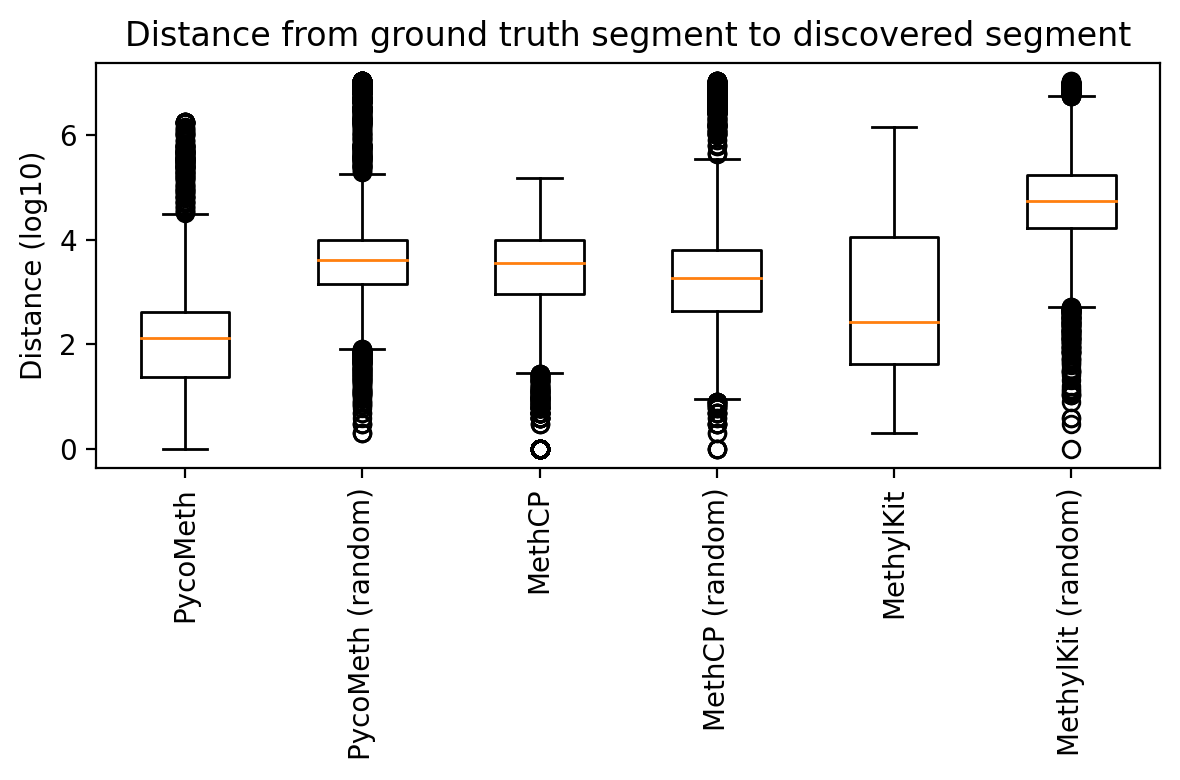

In [387]:
pa.figure()
tools = list(all_dists_from_gt.keys())
x = np.arange(len(tools))
plt.boxplot([np.log10(all_dists_from_gt[tool]+1) for tool in tools], positions=x)
plt.xticks(x, tools, rotation=90)
plt.title("Distance from ground truth segment to discovered segment")
plt.ylabel("Distance (log10)")
plt.show()

/tmp/ipykernel_46519/3605869150.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.boxplot([np.log10(all_dists_from_pred[tool]) for tool in tools], positions=x)


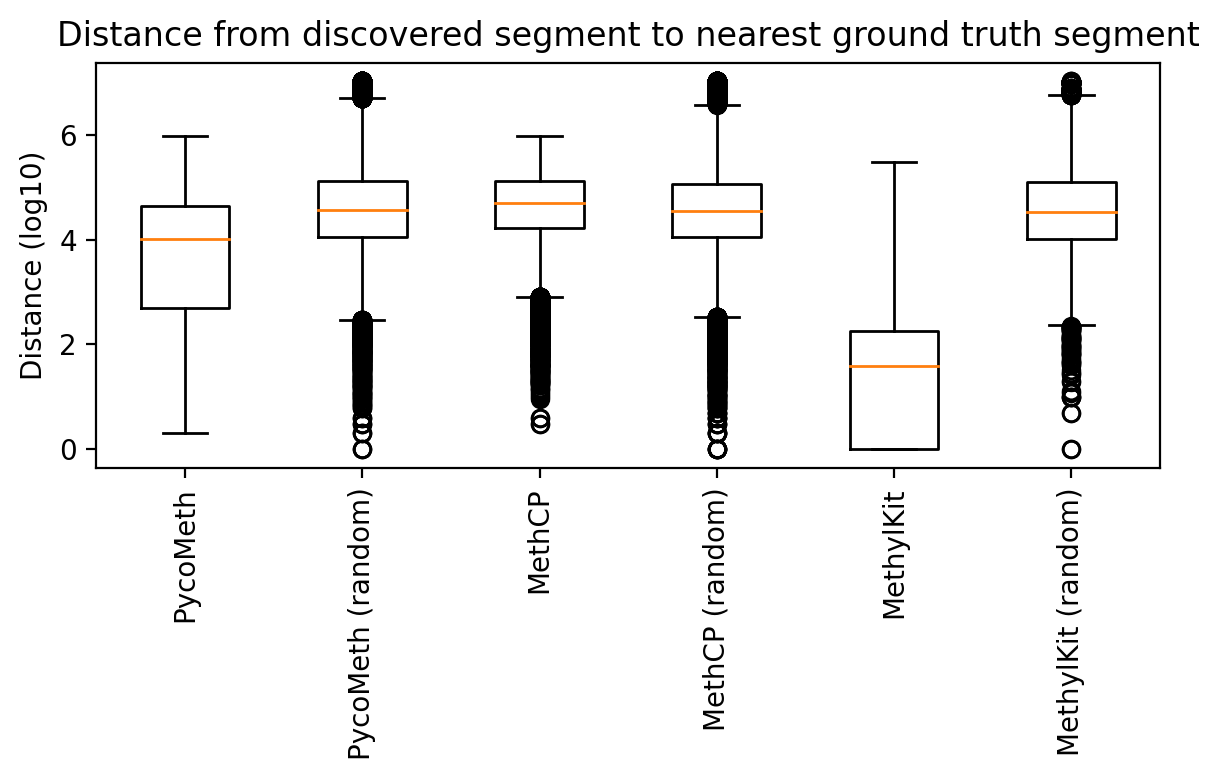

In [388]:
pa.figure()
tools = list(all_dists_from_pred.keys())
plt.boxplot([np.log10(all_dists_from_pred[tool]) for tool in tools], positions=x)
plt.xticks(x, tools, rotation=90)
plt.title("Distance from discovered segment to nearest ground truth segment")
plt.ylabel("Distance (log10)")
plt.show()

In [390]:
from nanoepitools.plotting.plot_methylation_profile import plot_met_profile_from_matrix, plot_met_profile
from meth5 import MetH5File
simulated_m5 = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/diffmet_merged.m5"
simulated_m5 = MetH5File(simulated_m5, "r")

def plot_methylation_all_segments(chrom, start, end):
    matrix = simulated_m5[chrom].get_values_in_range(start, end).to_sparse_methylation_matrix(read_groups_key="sample")
    fig, ax = pa.subplots(4,2, figsize=(20,8))
    for i, tool in enumerate(["GT", "PycoMeth", "MethCP", "MethylKit"]):
        if tool == "GT":
            seg = gt
        else:
            seg = sc.predicted_segments[tool]
        plt.sca(ax[i,0])
        plt.title(tool)
        plot_met_profile_from_matrix(matrix, aggregate_samples=True)
        plt.vlines(seg.loc[(seg["start"] > start)&(seg["start"] < end)]["start"], plt.ylim()[0], plt.ylim()[1])

        plt.sca(ax[i,1])
        if tool != "GT":
            tool = f"{tool} (random)"
            seg = sc.predicted_segments[tool]
            plt.title(tool)
            plot_met_profile_from_matrix(matrix, aggregate_samples=True)
            plt.vlines(seg.loc[(seg["start"] > start)&(seg["start"] < end)]["start"], plt.ylim()[0], plt.ylim()[1])
    plt.show()

713272 793989


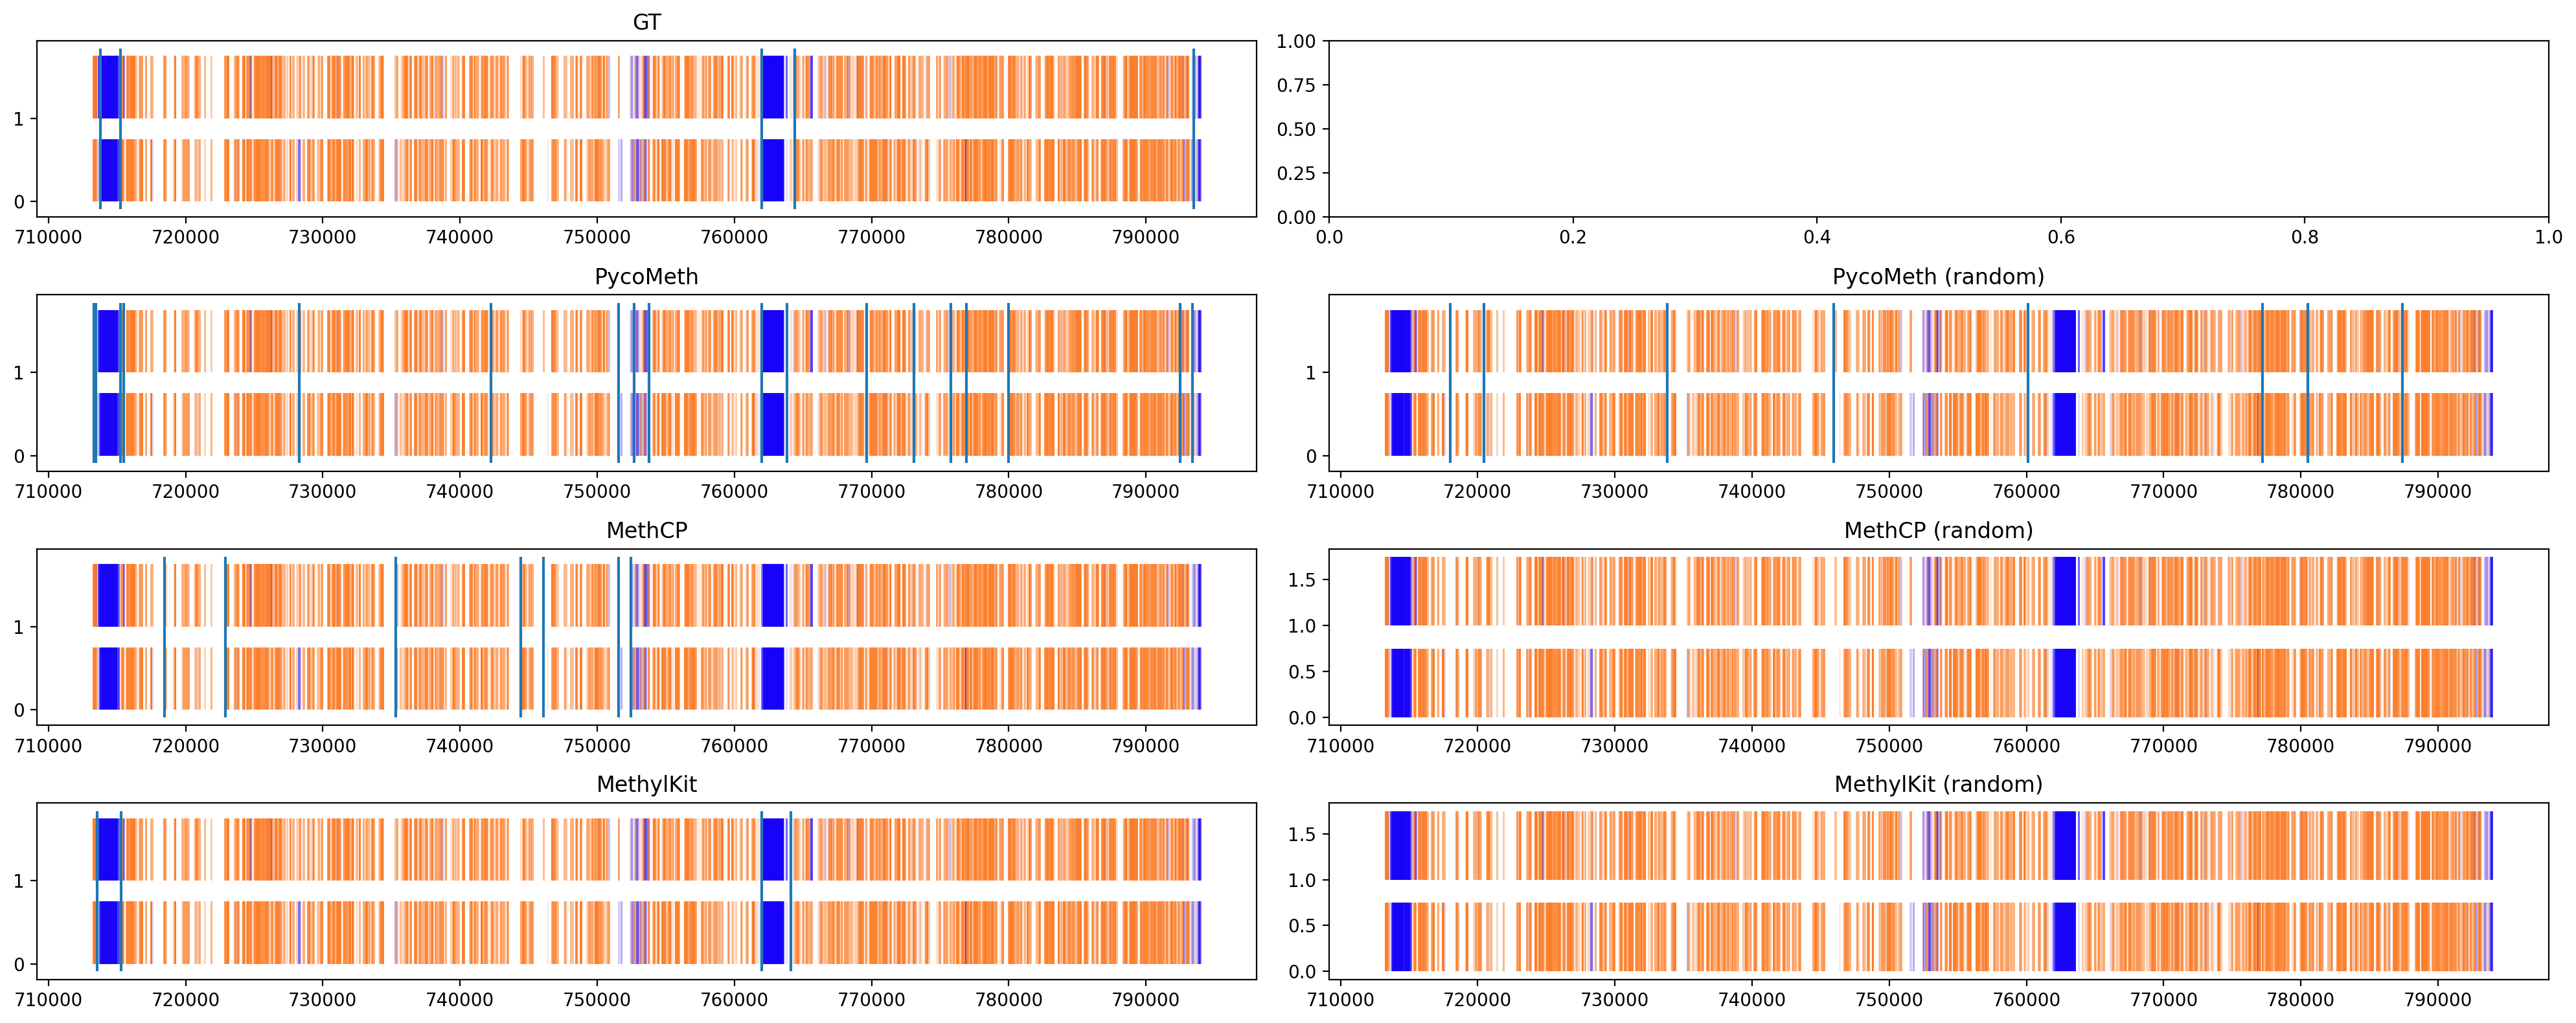

714749 796224


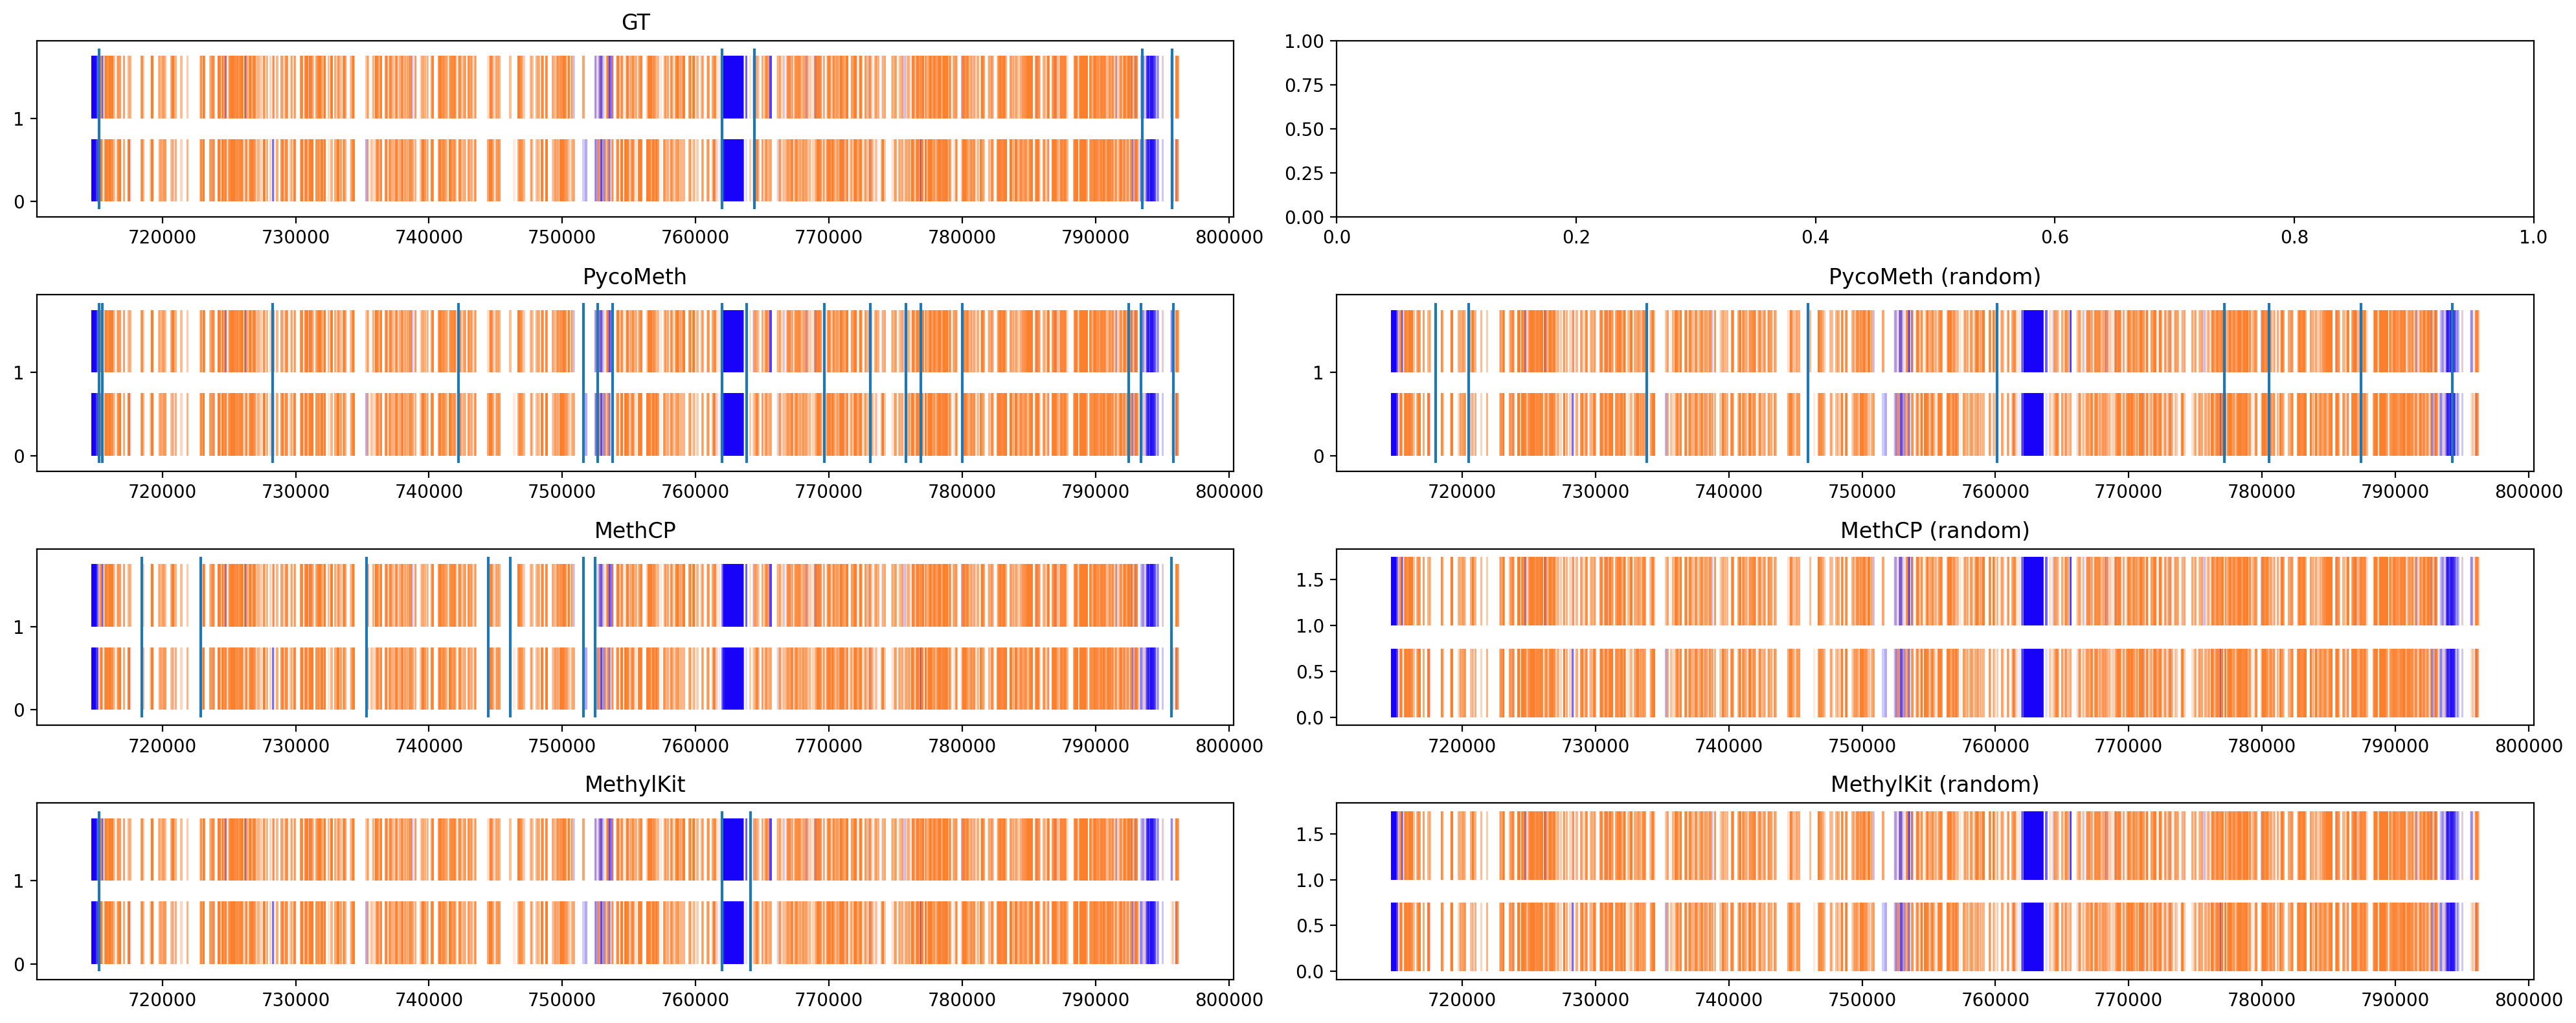

761503 805411



KeyboardInterrupt



In [391]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(len(gt)):
        toshow = gt.iloc[i:i+5]
        start, end = toshow.iloc[0]["start"]-500, toshow.iloc[-1]["start"]+500
        if end - start > 100000:
            continue
        print(start, end)
        plot_methylation_all_segments("1", start, end)

In [328]:
import importlib
import nanoepitools.plotting.plot_methylation_profile
importlib.reload(nanoepitools.plotting.plot_methylation_profile)
plot_met_profile_from_matrix= nanoepitools.plotting.plot_methylation_profile.plot_met_profile_from_matrix

{'PycoMeth': array([       140,     -17903,     -19546, ..., -249158268, -249189503,
        -249191075]),
 'PycoMeth (random)': array([       140,     -17903,     -19546, ..., -249158268, -249189503,
        -249191075]),
 'MethCP': array([       140,     -17903,     -19546, ..., -249158268, -249189503,
        -249191075]),
 'MethCP (random)': array([       140,     -17903,     -19546, ..., -249158268, -249189503,
        -249191075]),
 'MethylKit': array([      2202,     -15841,     -17484, ..., -249156206, -249187441,
        -249189013]),
 'MethylKit (random)': array([      2202,     -15841,     -17484, ..., -249156206, -249187441,
        -249189013])}